# Evaluation of the inferred coupling images to sequences
----

This notebook serves to evaluate the translation performance and thus the quality of the inferred coupling of a trained model to translate between two domains.

---

## 0. Environmental setup

First, we load the required libraries and software packages as well as fix the initialization of the pseudo-random number generators to ensure reproducibility of the analyses.

In [128]:
import sklearn
import numpy as np
import pandas as pd
import torch
import random
import sys

import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, Subset

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

seed = 1234
random.seed(seed)
np.random.seed(1234)

plt.rcParams["figure.figsize"] = (9,6)

sys.path.append("/home/daniel/PycharmProjects/domain_translation")

from src.data.datasets import TorchNucleiImageDataset
from src.utils.torch.general import get_device
from src.utils.basic.io import get_file_list

In [2]:
def plot_roc_for_stratified_cv(X, y, n_splits, classifier):
    cv = StratifiedKFold(n_splits=n_splits)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    return fig, ax, classifier

---

## 1. Read in data

Next we read in the data input data and the translated data for a run experiment.

In [3]:
root_dir = "/home/daniel/PycharmProjects/domain_translation/data/cd4/experiments/analyses_of_current_best/"

In [4]:
image_inputs_dir = root_dir + "input_images"
image_labels = pd.read_csv(root_dir + "image_labels.csv", index_col=0)
translated_pathway_activities = pd.read_csv(
    root_dir + "translated_pathway_activities.csv", index_col=0
)
translated_rna_sequences = pd.read_csv(
    root_dir + "translated_rna_sequences.csv", index_col=0
)

In [5]:
translated_image_dir = root_dir + "translated_images"
rna_inputs = pd.read_csv(root_dir + "rna_inputs.csv", index_col=0)
rna_labels = pd.read_csv(root_dir + "rna_labels.csv", index_col=0)
pathway_activities = pd.read_csv(root_dir + "pathway_activities.csv", index_col=0)

---

## 2. Validation of the image-to-sequence translation

First, we will quantify how much information is lost by inferring compressing the gene expression profiles into a set of pathway activity scores that is of a much lower dimensionality (339 pathways vs. 5,785 genes). To this end we will train a RandomForrest classifier on the gene expression data and compare the performance using 10-fold stratified cross-validation of the two classifiers.

---

### 2.1. Gene expression classifier

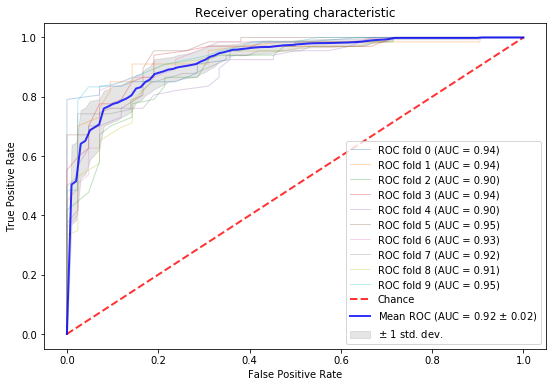

In [6]:
_, _, rna_classifier = plot_roc_for_stratified_cv(
    np.array(rna_inputs),
    np.array(rna_labels).ravel(),
    10,
    RandomForestClassifier(random_state=seed),
)

The mean AUC for the RandomForest classifier trained on the gene expression data of the 10-fold stratified cross-validation is 0.92 $\pm$ 0.02.

We will now compare this performance with the one we get when evaluating the trained classifier on gene expression data translated from the images.

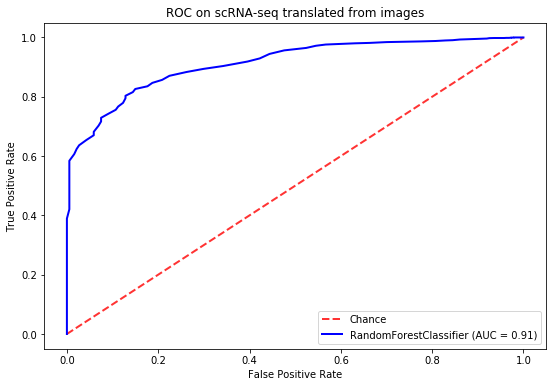

In [7]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plot_roc_curve(
    rna_classifier,
    np.array(translated_rna_sequences),
    np.array(image_labels).ravel(),
    lw=2,
    ax=ax,
    color="b",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC on scRNA-seq translated from images",
)
ax.legend(loc="lower right")

---

### 2.2. Pathway activity score classifier

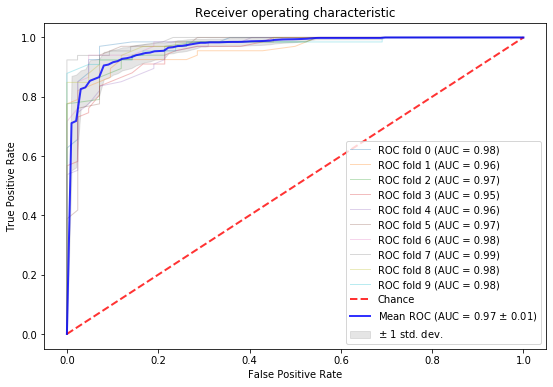

In [8]:
_, _, pas_classifier = fig, ax, classifier = plot_roc_for_stratified_cv(
    np.array(pathway_activities),
    np.array(rna_labels).ravel(),
    10,
    RandomForestClassifier(random_state=seed),
)

The mean AUC for a similar RandomForest classifier trained on the inferred pathway activity scores to predict whether or not a specific cell is part of the quiescent or poised sub-population of naive CD4+ T cells is 0.97$\pm$0.01.

An explanation for this increased performance compared to the classifier trained on the input gene expression data is that during inferring the parameters to estimate the pathway activity scores the label information were provided already.

---

## 3. Validation of the sequence-to-image translation

In [6]:
input_image_dataset = TorchNucleiImageDataset(image_dir=image_inputs_dir)
input_image_dataset.labels = np.array(image_labels).ravel()
input_image_dataset.ids = np.array(image_labels.index)

In [7]:
translated_image_dataset = TorchNucleiImageDataset(image_dir=translated_image_dir)
translated_image_dataset.labels = np.array(rna_labels).ravel()
translated_image_dataset.ids = np.array(rna_labels.index)

In [251]:
class ConvolutionalClassifier(nn.Module):
    def __init__(
        self,
        input_channels: int = 1,
        output_dim: int = 2,
        hidden_dims=[128, 256, 512, 1024, 1024],
        lrelu_slope: int = 0.2,
    ):
        super().__init__()
        self.in_channels = input_channels
        self.hidden_dims = hidden_dims
        self.lrelu_slope = lrelu_slope
        self.output_dim = output_dim

        feature_modules = [
            nn.Sequential(
                nn.Conv2d(
                    in_channels=self.in_channels,
                    out_channels=self.hidden_dims[0],
                    kernel_size=2,
                    stride=4,
                    padding=1,
                    bias=False,
                ),
                nn.LeakyReLU(lrelu_slope),
            )
        ]

        for i in range(1, len(self.hidden_dims)):
            feature_modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=self.hidden_dims[i - 1],
                        out_channels=self.hidden_dims[i],
                        kernel_size=4,
                        stride=2,
                        padding=1,
                        bias=False,
                    ),
                    nn.BatchNorm2d(self.hidden_dims[i]),
                    nn.LeakyReLU(lrelu_slope),
                )
            )
        self.feature_extractor = nn.Sequential(*feature_modules)
        self.feature_dropout= nn.Dropout()
        self.predictor = nn.Linear(1024, output_dim)

    def forward(self, inputs):
        features = self.feature_extractor(inputs).view(inputs.size(0), -1)
        features = self.feature_dropout(features)
        probs = self.predictor(features)
        return probs

In [252]:
conv_classifier = ConvolutionalClassifier()
print(conv_classifier)

ConvolutionalClassifier(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 128, kernel_size=(2, 2), stride=(4, 4), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (

After constructing the basic classifier model we will now split the data into a train and test set for the original input images. Performing 10-fold stratified cross-validation is not done to save some computation time. The split however is done also in a stratified manner.

In [253]:
data_idc = np.arange(0,len(input_image_dataset))
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
train_idc, test_idc = next(sss.split(data_idc, np.array(image_labels).ravel()))
train_idc, val_idc = next(sss.split(train_idc, np.array(image_labels).ravel()[train_idc]))

In [254]:
train_input_dataset = Subset(input_image_dataset, train_idc)
val_input_dataset = Subset(input_image_dataset, val_idc)
test_input_dataset = Subset(input_image_dataset, test_idc)

In [255]:
def class_imbalance_sampler(labels):
    class_sample_count = np.array([len(np.where(labels==t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
    return sampler

In [274]:
train_input_data_loader = DataLoader(train_input_dataset,batch_size=32)
val_input_data_loader = DataLoader(val_input_dataset, batch_size=32)
test_input_data_loader = DataLoader(test_input_dataset, batch_size=32)

In [275]:
device = get_device()
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0,1.0]).to(device))
optimizer = torch.optim.Adam(conv_classifier.parameters(), lr=0.0001, weight_decay=0.005)

In [276]:
def train_binary_image_classifier(
    classifier,
    criterion,
    optimizer,
    train_data_loader,
    val_data_loader,
    n_epochs,
    data_key="image",
    label_key="label",
):
    device = get_device()
    classifier.to(device)

    for epoch in range(n_epochs):
        print("Start epoch {}".format(epoch))
        classifier.train()
        epoch_loss = 0
        epoch_roc_auc = 0
        all_image_labels = []
        all_image_prob_preds = []
        for i, sample in enumerate(train_data_loader):
            optimizer.zero_grad()
            image_inputs = sample[data_key].to(device)
            image_labels = sample[label_key].to(device)

            prediction = classifier(image_inputs)

            loss = criterion(prediction, image_labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pred_probs = nn.functional.softmax(prediction, 1)[:, 1]
            all_image_labels.extend(list(image_labels.clone().detach().cpu().numpy().ravel()))
            all_image_prob_preds.extend(list(pred_probs.clone().detach().cpu().numpy().ravel()))
        epoch_loss = epoch_loss / len(train_data_loader)
        epoch_roc_auc = roc_auc_score(np.array(all_image_labels), np.array(all_image_prob_preds))
        print("Train loss: {}".format(epoch_loss))
        print("Train ROC-AUC: {}".format(epoch_roc_auc))

        classifier.eval()
        epoch_loss = 0
        epoch_roc_auc = 0
        all_image_labels = []
        all_image_prob_preds = []
        for i, sample in enumerate(val_data_loader):
            image_inputs = sample[data_key].to(device)
            image_labels = sample[label_key].to(device)

            prediction = classifier(image_inputs)

            loss = criterion(prediction, image_labels)

            epoch_loss += loss.item()
            pred_probs = nn.functional.softmax(prediction, 1)[:, 1]
            all_image_labels.extend(list(image_labels.clone().detach().cpu().numpy().ravel()))
            all_image_prob_preds.extend(list(pred_probs.clone().detach().cpu().numpy().ravel()))
        epoch_loss = epoch_loss / len(train_data_loader)
        epoch_roc_auc = roc_auc_score(np.array(all_image_labels), np.array(all_image_prob_preds))
        print("Val loss: {}".format(epoch_loss))
        print("Val ROC-AUC: {}".format(epoch_roc_auc))
        
    return classifier

In [277]:
fitted_classifier = train_binary_image_classifier(
    conv_classifier, criterion, optimizer, train_input_data_loader, val_input_data_loader, 20
)

Start epoch 0
Train loss: 0.48102243275692064
Train ROC-AUC: 0.477434185588692
Val loss: 0.08498943876475096
Val ROC-AUC: 0.43496922578555236
Start epoch 1
Train loss: 0.2871862663887441
Train ROC-AUC: 0.5898780920240148
Val loss: 0.08358019667988022
Val ROC-AUC: 0.5093132491091674
Start epoch 2
Train loss: 0.2628676180417339
Train ROC-AUC: 0.6873739041121015
Val loss: 0.10038947189847629
Val ROC-AUC: 0.43391642371234207
Start epoch 3
Train loss: 0.23611987056210637
Train ROC-AUC: 0.7727339422618393
Val loss: 0.09829619061201811
Val ROC-AUC: 0.4643666990605766
Start epoch 4
Train loss: 0.20085076708346605
Train ROC-AUC: 0.8646845921524031
Val loss: 0.13073704671114683
Val ROC-AUC: 0.41091674765144154
Start epoch 5
Train loss: 0.17372637536997595
Train ROC-AUC: 0.9104581636770477
Val loss: 0.26565632099906605
Val ROC-AUC: 0.49092970521541945
Start epoch 6
Train loss: 0.14207969442941248
Train ROC-AUC: 0.9416626927356542
Val loss: 0.13400393103559813
Val ROC-AUC: 0.48485584710074503
Star

KeyboardInterrupt: 

In [265]:
translated_image_dataset = TorchNucleiImageDataset(image_dir=translated_image_dir)
translated_image_dataset.labels = np.array(rna_labels).ravel()
translated_image_dataset.ids = np.array(rna_labels.index)
trans_img_dl = DataLoader(translated_image_dataset, batch_size=32)

After training the model we will now derive the predictions for the test portion of the data set.

In [182]:
def get_labels_and_predictions_for_classifier(
    classifier, test_data_loader, data_key="image", label_key="label"
):
    device = get_device()
    classifier.eval()
    classifier.to(device)
    preds = []
    labels = []
    for i, sample in enumerate(test_data_loader):
        image_inputs = sample[data_key].to(device)
        labels.extend(list(sample[label_key].detach().cpu().numpy()))

        prediction = nn.functional.softmax(classifier(image_inputs),1)[:,1]
        preds.extend(list(prediction.detach().cpu().numpy()))
    return np.array(preds), np.array(labels)

In [183]:
train_eval_data_loader = DataLoader(train_input_dataset, batch_size=32)
input_image_predictions, input_image_labels = get_labels_and_predictions_for_classifier(
    fitted_classifier, trans_img_dl
)

Let us now compute the ROC for the image classifier trained on the input images.

In [187]:
input_image_fpr, input_image_tpr, _ = roc_curve(np.array(input_image_labels), np.array(input_image_predictions), pos_label=1)
input_image_auc = roc_auc_score(np.array(input_image_labels), np.array(input_image_predictions))

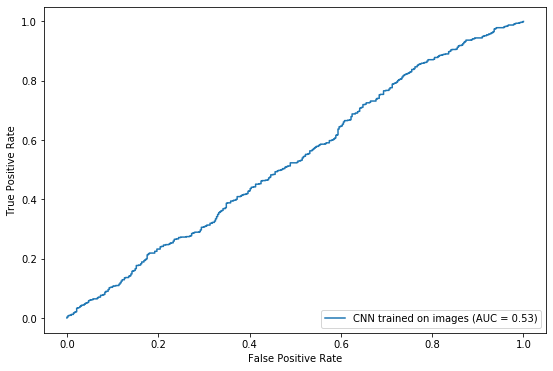

In [188]:
display = RocCurveDisplay(fpr=input_image_fpr, tpr=input_image_tpr, roc_auc=input_image_auc, estimator_name='CNN trained on images')
display.plot()  
plt.show()     